# Lab 2

## Kalman-Filter mit Messaussetzer in Beta-, Alpha- und Gamma-Filter


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib widget
# %matplotlib inline

DATAFILE = "data/Messaussetzer_data_in.dat"
df = pd.read_csv(DATAFILE, sep=" ")
t = df["time"].to_numpy()
y = df["position"].to_numpy()
u = np.zeros(len(y))
Ts = t[1] - t[0]

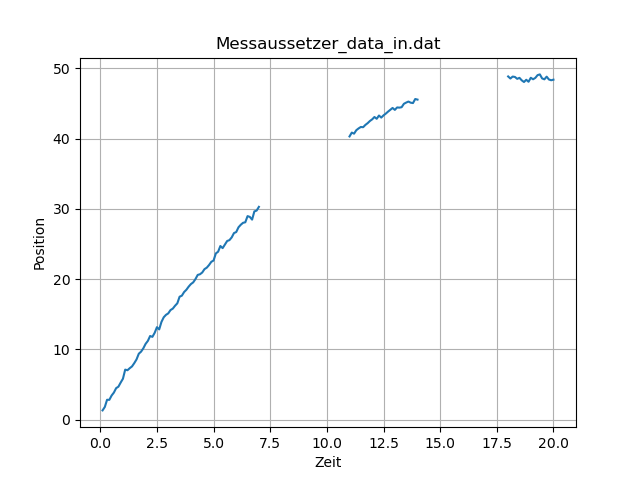

In [16]:
plt.figure()
plt.title("Messaussetzer_data_in.dat")
plt.xlabel("Zeit")
plt.ylabel("Position")
plt.grid(True)
plt.plot(t, y)
plt.show()


In [17]:
y_filtered = []
for i in range(len(t)):
    if str(y[i]) == "nan":
        break
    else:
        y_filtered.append(y[i])

y_rand_var = []
for i in range(0, 3, 1):
    y_rand_temp = random.choices(y_filtered[0 : len(y_filtered)], k=50)

    y_rand_var.append(np.var(y_rand_temp))

print(np.var(y_rand_var))

R = min(y_rand_var)
Q = [0.016667]
print(f"R={R}, Q={Q}")

non_nan = ~np.isnan(y)
R = np.var(y[np.argwhere(non_nan == False)[-1][0] + 1 :])
print(f"R={R}, Q={Q}")


17.140288452012182
R=72.6769176011898, Q=[0.016667]
R=0.07515963685972159, Q=[0.016667]


### Beta-Filter

$$
\boldsymbol{x}(k + 1) = \begin{bmatrix}
1 & T_s \\
0 & 1 \\
\end{bmatrix} \cdot \begin{bmatrix}
s(k) \\
v(k)
\end{bmatrix} + \begin{bmatrix}
0 \\
0 \\
\end{bmatrix} \cdot \boldsymbol{u}(k) + \begin{bmatrix}
T_s \\
1 \\
\end{bmatrix} \cdot \boldsymbol{z}(k)
$$

$$
\boldsymbol{y}(k) = s(t) = \begin{bmatrix}
1 & 0 \\
\end{bmatrix} \cdot \begin{bmatrix}
s(t) \\
v(t) \\
\end{bmatrix} + \begin{bmatrix}
0 \\
\end{bmatrix} \cdot u(k)
$$


In [18]:
# Define system matrices
Ad = np.array(
    [
        [1, Ts],
        [0, 1],
    ]
)
Bd = np.array(
    [
        [0],
        [0],
    ]
)
C = np.array([1, 0])
D = np.array([0])
Gd = np.array(
    [
        [Ts],
        [1],
    ]
)

# Initialization
x_dach = np.array([[y[0]], [0]])  # estimate
P_dach = 30 * np.eye(Bd.size)

s = np.zeros(len(y))  # prediction output array
v = np.zeros(len(y))  # variation
d_y = np.zeros(len(y))  # new error
y_dach = np.zeros(len(y))  # error

P_tilde0 = np.zeros(len(y))
P_tilde1 = np.zeros(len(y))
P_tilde2 = np.zeros(len(y))
P_tilde3 = np.zeros(len(y))


In [19]:
for i, y_i in enumerate(y):
    if np.isnan(y_i):
        x_tilde = x_dach
        P_tilde = P_dach
    else:
        y_dach[i] = C @ x_dach + D * u[i]
        d_y[i] = y_i - y_dach[i]
        # K = P_dach @ C.reshape(-1,1) * (C @ P_dach @ C.reshape(-1,1) + R) ** (-1) # previous method
        k = C @ P_dach @ C.reshape(-1, 1) + R
        if k.ndim >= 2:
            K = (
                P_dach @ C.reshape(-1, 1) @ np.linalg.pinv(k)
            )  # penrose inverse works with k dimension greater 2
        else:
            K = P_dach @ C.reshape(-1, 1) / k  # use plain inverse otherwise

        x_tilde = x_dach + K * d_y[i]
        P_tilde = (np.eye(Bd.size) - K * C) @ P_dach
    # print(P_tilde)

    x_dach = Ad @ x_tilde + Bd * u[i]
    P_dach = Ad @ P_tilde @ Ad.T + (Gd * Q) @ Gd.T

    s[i], v[i] = x_tilde

    P_tilde0 = P_tilde[0][0]
    P_tilde1 = P_tilde[0][1]
    P_tilde2 = P_tilde[1][0]
    P_tilde3 = P_tilde[1][1]


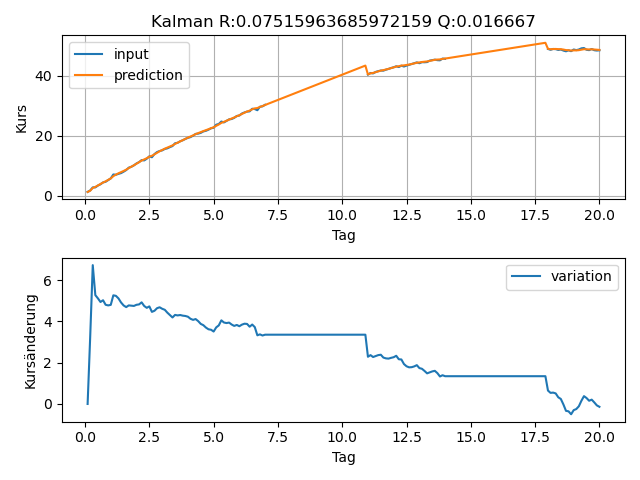

In [20]:
plt.figure()
plt.subplot(2, 1, 1)
plt.title(f"Kalman R:{R} Q:{Q[0]}")
plt.xlabel("Tag")
plt.ylabel("Kurs")
plt.grid(True)
plt.plot(t, y, label="input")
plt.plot(t, s, label="prediction")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, v, label="variation")
plt.xlabel("Tag")
plt.ylabel("Kursänderung")
plt.legend()
plt.tight_layout()
plt.show()


### Alpha-Filter

$$
x(k + 1) = \begin{bmatrix}
1 \\
\end{bmatrix} \cdot \begin{bmatrix}
s(k) \\
\end{bmatrix} + \begin{bmatrix}
0 \\
\end{bmatrix} \cdot u(k) + \begin{bmatrix}
1 \\
\end{bmatrix} \cdot z(k)
$$

$$
\boldsymbol{y}(k) = s(t) = \begin{bmatrix}
1 \\
\end{bmatrix} \cdot \begin{bmatrix}
s(t) \\
\end{bmatrix} + \begin{bmatrix}
0 \\
\end{bmatrix} \cdot u(k)
$$


In [21]:
R = R
Q = [0.16667]


In [22]:
# Define system matrices
Ad = np.array([[1]])
Bd = np.array([[0]])
C = np.array([1])
D = np.array([0])
Gd = np.array([[1]])

# Initialization
x_dach = np.array([[y[0]]])  # estimate
P_dach = 30 * np.eye(Bd.size)

s = np.zeros(len(y))  # prediction output array
d_y = np.zeros(len(y))  # new error
y_dach = np.zeros(len(y))  # error

P_tilde0 = np.zeros(len(y))


In [23]:
for i, y_i in enumerate(y):
    if np.isnan(y_i):
        x_tilde = x_dach
        P_tilde = P_dach
    else:
        y_dach[i] = C @ x_dach + D * u[i]
        d_y[i] = y_i - y_dach[i]
        # K = P_dach @ C.reshape(-1,1) * (C @ P_dach @ C.reshape(-1,1) + R) ** (-1) # previous method
        k = C @ P_dach @ C.reshape(-1, 1) + R
        if k.ndim >= 2:
            K = (
                P_dach @ C.reshape(-1, 1) @ np.linalg.pinv(k)
            )  # penrose inverse works with k dimension greater 2
        else:
            K = P_dach @ C.reshape(-1, 1) / k  # use plain inverse otherwise

        x_tilde = x_dach + K * d_y[i]
        P_tilde = (np.eye(Bd.size) - K * C) @ P_dach
    # print(P_tilde)

    x_dach = Ad @ x_tilde + Bd * u[i]
    P_dach = Ad @ P_tilde @ Ad.T + (Gd * Q) @ Gd.T

    s[i] = x_tilde

    P_tilde0 = P_tilde[0][0]


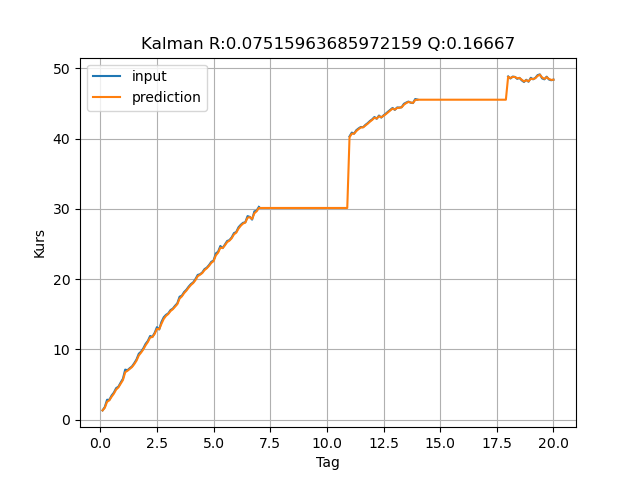

In [24]:
plt.figure()
plt.title(f"Kalman R:{R} Q:{Q[0]}")
plt.xlabel("Tag")
plt.ylabel("Kurs")
plt.grid(True)
plt.plot(t, y, label="input")
plt.plot(t, s, label="prediction")
plt.legend()


### Gamma-Filter

$$
\boldsymbol{x}(k + 1) = \begin{bmatrix}
1 & T_s & \frac{T_s^2}{2} \\
0 & 1 & T_s \\
0 & 0 & 1 \\
\end{bmatrix} + \begin{bmatrix}
0 \\
0 \\
0 \\
\end{bmatrix} \cdot \boldsymbol{u}(k) + \begin{bmatrix}
\frac{T_s^2}{2} \\
T_s \\
1 \\
\end{bmatrix} \cdot \boldsymbol{z}(k)
$$

$$
y(k) = \begin{bmatrix}
1 & 0 & 0 \\
\end{bmatrix} \cdot \begin{bmatrix}
s(k) \\
v(k) \\
a(k) \\
\end{bmatrix} + \begin{bmatrix}
0 \\
0 \\
0 \\
\end{bmatrix} \cdot \boldsymbol{u}(k)
$$


In [25]:
R = R
Q = [0.16667]


In [26]:
# Define system matrices
Ad = np.array(
    [
        [1, Ts, 0.5 * Ts**2],
        [0, 1, Ts],
        [0, 0, 1],
    ]
)
Bd = np.array(
    [
        [0],
        [0],
        [0],
    ]
)
C = np.array([1, 0, 0])
D = np.array([0])
Gd = np.array(
    [
        [0.5 * Ts**2],
        [Ts],
        [1],
    ]
)

# Initialization
x_dach = np.array([[y[0]], [0], [0]])  # estimate
P_dach = 30 * np.eye(Bd.size)

s = np.zeros(len(y))  # prediction output array
v = np.zeros(len(y))  # variation
a = np.zeros(len(y))
d_y = np.zeros(len(y))  # new error
y_dach = np.zeros(len(y))  # error

P_tilde0 = np.zeros(len(y))
P_tilde1 = np.zeros(len(y))
P_tilde2 = np.zeros(len(y))
P_tilde3 = np.zeros(len(y))
P_tilde4 = np.zeros(len(y))
P_tilde5 = np.zeros(len(y))
P_tilde6 = np.zeros(len(y))
P_tilde7 = np.zeros(len(y))
P_tilde8 = np.zeros(len(y))


In [27]:
for i, y_i in enumerate(y):
    if np.isnan(y_i):
        x_tilde = x_dach
        P_tilde = P_dach
    else:
        y_dach[i] = (
            C @ x_dach + D * u[i]
        )  # korrigierter Wert ermittelt aus vorherigen Werten
        d_y[i] = y_i - y_dach[i]  # aktuellen (neuen) Fehler bestimmen
        # K = P_dach @ C.reshape(-1,1) * (C @ P_dach @ C.reshape(-1,1) + R) ** (-1) # previous method
        k = C @ P_dach @ C.reshape(-1, 1) + R
        if k.ndim >= 2:
            K = (
                P_dach @ C.reshape(-1, 1) @ np.linalg.pinv(k)
            )  # penrose inverse works with k dimension greater 2
        else:
            K = P_dach @ C.reshape(-1, 1) / k  # use plain inverse otherwise

        x_tilde = x_dach + K * d_y[i]
        P_tilde = (np.eye(Bd.size) - K * C) @ P_dach

    # print(f"y: {y_i:.3f}\t y_dach: {y_dach[i]:.3f}\t d_y: {d_y[i]:.3f}")

    x_dach = Ad @ x_tilde + Bd * u[i]
    P_dach = Ad @ P_tilde @ Ad.T + (Gd * Q) @ Gd.T

    s[i], v[i], a[i] = x_tilde

    P_tilde0 = P_tilde[0][0]
    P_tilde1 = P_tilde[0][1]
    P_tilde2 = P_tilde[0][2]
    P_tilde3 = P_tilde[1][0]
    P_tilde4 = P_tilde[1][1]
    P_tilde5 = P_tilde[1][2]
    P_tilde6 = P_tilde[2][0]
    P_tilde7 = P_tilde[2][1]
    P_tilde8 = P_tilde[2][2]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


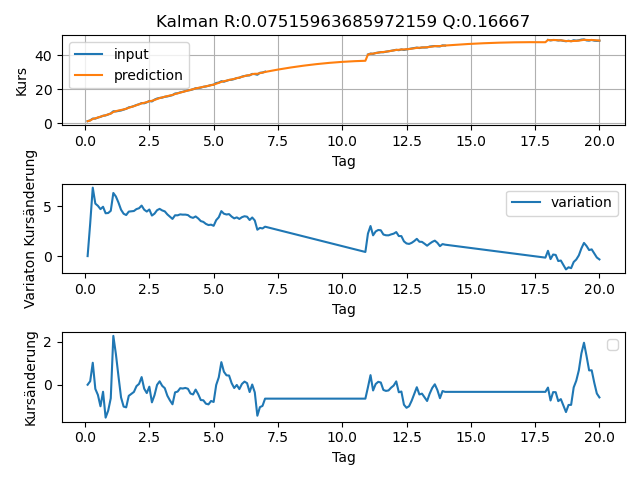

In [28]:
plt.figure()
plt.subplot(3, 1, 1)
plt.title(f"Kalman R:{R} Q:{Q[0]}")
plt.xlabel("Tag")
plt.ylabel("Kurs")
plt.grid(True)
plt.plot(t, y, label="input")
plt.plot(t, s, label="prediction")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t, v, label="variation")
plt.xlabel("Tag")
plt.ylabel("Variaton Kursänderung")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t, a, label="")
plt.xlabel("Tag")
plt.ylabel("Kursänderung")
plt.legend()

plt.tight_layout()
plt.show()
